In [6]:
import pandas as pd
import os


In [2]:
% ls

Untitled.ipynb        training-dataset/     training-dataset.zip


In [4]:
df = pd.read_csv('training-dataset/latest_training_data.csv')

In [5]:
df.head()

,image_id,label
0,BreastHistoTTD_1029,1
1,BreastHistoTTD_1035,1
2,BreastHistoTTD_389,1
3,BreastHistoTTD_1086,1
4,BreastHistoTTD_411,1


In [5]:
df.label.value_counts()

1    1107
0     493
Name: label, dtype: int64

In [1]:
import torch


In [2]:
torch.__version__

'1.0.1.post2'

In [90]:
df['image_path'] = df['image_id'].map(lambda x: os.path.join('training-dataset','latest_training_data1',x+'.png'))

In [91]:
df.head()

,image_id,label,image_path
0,BreastHistoTTD_1029,1,training-dataset/latest_training_data1/BreastH...
1,BreastHistoTTD_1035,1,training-dataset/latest_training_data1/BreastH...
2,BreastHistoTTD_389,1,training-dataset/latest_training_data1/BreastH...
3,BreastHistoTTD_1086,1,training-dataset/latest_training_data1/BreastH...
4,BreastHistoTTD_411,1,training-dataset/latest_training_data1/BreastH...


In [92]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.10)

In [93]:
print(df_train['label'].value_counts()) 
print(df_test['label'].value_counts())

1    997
0    443
Name: label, dtype: int64
1    110
0     50
Name: label, dtype: int64


In [94]:
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, utils

In [95]:
class GenomeDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        img = Image.open(self.df.iloc[idx].loc['image_path'])
        
        if self.transform:
            img = self.transform(img)
            
        if self.training:    
            label = self.df.iloc[idx].loc['label']
            return img,  label
        else:
            return img

In [164]:
normalize = transforms.Normalize(
   mean=[0.5, 0.5, 0.5],
   std=[0.5, 0.5, 0.5]
)

trans_train = transforms.Compose([
    transforms.Resize([224,224]),
#     transforms.Pad(64, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),   
#     transforms.RandomRotation(20),
#     transforms.RandomCrop(224),
    transforms.ToTensor(),
    normalize
])

# trans_test = transforms.Compose([
#     transforms.Resize([224,224]),
#     transforms.ToTensor(),
#     normalize
# ])

train_ds = GenomeDataset(df_train, transform=trans_train)
# val_ds = DogVsCatDataset(val, transform=ds_trans)
# test_ds = DogVsCatDataset(test, transform=test_trans, training=False)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
# val_dl = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=0)
# test_dl = DataLoader(test_ds, batch_size=6, num_workers=0)

In [148]:
test_img  = train_ds[1][0]
test_img

tensor([[[ 0.4510,  0.4431,  0.4980,  ...,  0.3176,  0.5216,  0.4353],
         [ 0.3255,  0.3490,  0.3961,  ...,  0.1922,  0.3804,  0.4588],
         [ 0.2000,  0.2784,  0.3725,  ...,  0.0745,  0.2784,  0.4667],
         ...,
         [ 0.4431,  0.1608,  0.1608,  ...,  0.7804,  0.7569,  0.7176],
         [ 0.3961,  0.2784,  0.2235,  ...,  0.7804,  0.7961,  0.7804],
         [ 0.3176,  0.3255,  0.2941,  ...,  0.7647,  0.7725,  0.7490]],

        [[ 0.1059,  0.0902,  0.1373,  ...,  0.0745,  0.3255,  0.2549],
         [ 0.0039,  0.0118,  0.0667,  ..., -0.0353,  0.1686,  0.2706],
         [-0.1137, -0.0510,  0.0275,  ..., -0.1373,  0.0667,  0.2549],
         ...,
         [ 0.2235, -0.0275, -0.0039,  ...,  0.6784,  0.6627,  0.6314],
         [ 0.2000,  0.0745,  0.0196,  ...,  0.6941,  0.6941,  0.6863],
         [ 0.1294,  0.1216,  0.0745,  ...,  0.6784,  0.6627,  0.6471]],

        [[ 0.5922,  0.5765,  0.5922,  ...,  0.4588,  0.6314,  0.5765],
         [ 0.4980,  0.5059,  0.5373,  ...,  0

In [149]:
test_img.size()

torch.Size([3, 352, 352])

In [150]:
import matplotlib.pyplot as plt

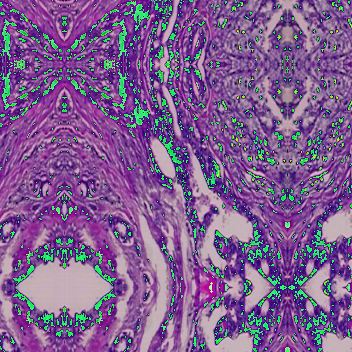

In [151]:
toPIL = transforms.ToPILImage()
toPIL(test_img)

In [152]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [153]:
## Parameters for model

# Hyper parameters
num_epochs = 7
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [154]:
model = SimpleCNN().to(device)

In [155]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [165]:
# Train the model
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/7], Step [2/45], Loss: 0.4818
Epoch [1/7], Step [4/45], Loss: 0.5400
Epoch [1/7], Step [6/45], Loss: 0.5667
Epoch [1/7], Step [8/45], Loss: 0.5002
Epoch [1/7], Step [10/45], Loss: 0.3782
Epoch [1/7], Step [12/45], Loss: 0.4132
Epoch [1/7], Step [14/45], Loss: 0.3393
Epoch [1/7], Step [16/45], Loss: 0.3385


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a26d90eb8>>
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a277da748>>
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataload

Epoch [1/7], Step [18/45], Loss: 0.5722


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a26d90eb8>>
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a277da748>>
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataload

Epoch [1/7], Step [20/45], Loss: 0.2490
Epoch [1/7], Step [22/45], Loss: 0.4166
Epoch [1/7], Step [24/45], Loss: 0.3034
Epoch [1/7], Step [26/45], Loss: 0.3693
Epoch [1/7], Step [28/45], Loss: 0.6050
Epoch [1/7], Step [30/45], Loss: 0.2878
Epoch [1/7], Step [32/45], Loss: 0.4229


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/williamardianto/miniconda3/envs/dlenv/lib/python3.6/multiprocessing/queues.py", line 240, in _feed


KeyboardInterrupt: 